# Predicting house prices with k-nearest neighbors regression
In this notebook, we
  * find the k-nearest neighbors of a given query input,
  * predict the output value for the query input using the K-NN,
  * explore different values for K in various models and picking the best one using a validation set.

In [57]:
import turicreate as tc
import numpy as np

Loading house sales data: We use a smaller subset of the King County housing dataset (40% of original)

In [58]:
sales = tc.SFrame('../data/home_data_small.sframe/')

#### Importing functions from previous notebooks

To compute pairwise distances among datapoints, we have to convert the SFrame into a 2D Numpy array, using the same `get_numpy_data()` from the notebook "Lasso_Coord_Descent_W5A2.ipynb"

In [59]:
"""Receives an SFrame, a list of input feature names, and the name of output target.
    Returns the data matrix as a 2d numpy array, and the outcome vector as an np array"""
def get_numpy_data(data_sframe, features, target):
    # Add constant column for the Intercept
    data_sframe['constant'] = 1
    features = ['constant'] + features
    
    # Subselect the features from the original including constant and convert into numpy matrix
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    
    # Subselect the target vector and convert into numpy array
    output_sarray = data_sframe[target]
    output_array = output_sarray.to_numpy()
    
    return (feature_matrix, output_array)

We also reuse the function `normalize_features()` which normalizes all feature columns to unit norm. 
This function comes from the notebook "Lasso_Feature_Selection_W5A1.ipynb"

In [60]:
"""Receives a numpy matrix (i.e. a 2D numpy array), 
    returns a numpy matrix with normalized feature columns, and a numpy array of the 2-norms"""
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = feature_matrix / norms
    
    return (normalized_features, norms)

#### Splitting data into training, test, and validation sets

In [61]:
# Split into Train&Validation / Test
(train_and_validation, test) = sales.random_split(.8, seed=1)
# Split into Training set / Validation set
(train, validation) = train_and_validation.random_split(.8, seed=1) # split training set into training and validation sets

#### Extracting and normalizing features

In [62]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']

# Obtain train, test and validation sets and output arrays as numpy data structures
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

For computing distances, it is crucial to normalize features. Otherwise, for example, the `sqft_living` feature (typically thousands) would exert a much larger influence on distance than the `bedrooms` feature (typically less than 10). 
<br>
To normalize, we divide each column of the training feature matrix by its **2-norm**, so that the transformed column has unit norm.

_IMPORTANT: Store in a variable the norms of the features of the training set; our datasets training, test, and validation must be normalized consistently._

In [63]:
# Normalize training set
features_train, NORMS = normalize_features(features_train) 

# Normalize test set
features_test = features_test / NORMS 

# Normalize validation set
features_valid = features_valid / NORMS 

## Computing the distance between two points

Take the **query house** to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

Print the **first and tenth rows of the test feature matrix**. 

_We should get an 18-dimensional vector with components in the range between 0 and 1._

In [64]:
features_test[0]

array([ 0.01345102,  0.01551285,  0.01807473,  0.01759212,  0.00160518,
        0.017059  ,  0.        ,  0.05102365,  0.0116321 ,  0.01564352,
        0.01362084,  0.02481682,  0.01350306,  0.        ,  0.01345386,
       -0.01346927,  0.01375926,  0.0016225 ])

In [65]:
features_train[9]

array([ 0.01345102,  0.01163464,  0.00602491,  0.0083488 ,  0.00050756,
        0.01279425,  0.        ,  0.        ,  0.01938684,  0.01390535,
        0.0096309 ,  0.        ,  0.01302544,  0.        ,  0.01346821,
       -0.01346254,  0.01195898,  0.00156612])

***QUIZ QUESTION: What is the Euclidean distance between the query house and the 10th house of the training set?  ***
`A = 0.60 (rounded to three decimals)`

In [150]:
"""
Receives two numpy arrays.
Computes and returns the euclidean distance between both.
"""
def euclidean_distance(xq, xi):
    D = len(xq)
    temp = [0 for _ in range(D)]  # stores element-wise square differences 
    
    for j in range(D):
        temp[j] = (xq[j] - xi[j])**2

    return np.sqrt(np.sum(temp))   # sum the elements and take the square root

# Note: Dont use the `np.linalg.norm` function; 
# use `np.sqrt`, `np.sum`, and the power operator (`**`) instead: 
# this approach is more easily adapted to computing multiple distances at once.

In [152]:
euclidean_distance(features_test[0], features_train[9])

0.05972359371666126

# Compute multiple distances

In nearest neighbor regression, we need to compute the distances between a query house and *all* of houses in the training set.  

As an exercise, we write a loop to compute the Euclidean distance from the query house to each of the first 10 houses in the training set.

In [157]:
# compute the distance from query house (`features_test[0]`) 
# to the first 10 houses of train set (`features_train[0:10]`)
query = features_test[0]
houses = features_train[0:10]
distances = []

for h in houses:
    d = euclidean_distance(query, h)
    distances.append(d)

# scan for the nearest neighbor within this small set of houses
index = distances.index(min(distances))
print(f"Nearest neighbor {index}")

Nearest neighbor 8


*** QUIZ QUESTION ***

Among the first 10 training houses, which house is the closest to the query house?
`A = the 9th one (index 8)`

### Vectorized numpy operations for computing multiple distances at once
It is inefficient to loop over computing distances to all houses in our training dataset. 
<br>
Instead, we can use Numpy's **vectorized** operations, which apply the same operation over multiple vectors (arrays) in concurrent or parallel fashion.

This loop computes the element-wise difference between the query house (`features_test[0]`) and the first 3 training houses (`features_train[0:3]`):

In [69]:
# Compute the vector substraction for three observations

print(features_train[0:3] - features_test[0])  
# Three substractions are performed, the second argument remaining constant in all 3 of them

[[ 0.00000000e+00 -3.87821276e-03 -1.20498190e-02 -1.05552733e-02
   2.08673616e-04 -8.52950206e-03  0.00000000e+00 -5.10236549e-02
   0.00000000e+00 -3.47633726e-03 -5.50336860e-03 -2.48168183e-02
  -1.63756198e-04  0.00000000e+00 -1.70072004e-05  1.30577772e-05
  -5.14364795e-03  6.69281453e-04]
 [ 0.00000000e+00 -3.87821276e-03 -4.51868214e-03 -2.26610387e-03
   7.19763456e-04  0.00000000e+00  0.00000000e+00 -5.10236549e-02
   0.00000000e+00 -3.47633726e-03  1.30705004e-03 -1.45830788e-02
  -1.91048898e-04  6.65082271e-02  4.23240653e-05  6.22415897e-06
  -2.89330197e-03  1.47606982e-03]
 [ 0.00000000e+00 -7.75642553e-03 -1.20498190e-02 -1.30002801e-02
   1.60518166e-03 -8.52950206e-03  0.00000000e+00 -5.10236549e-02
   0.00000000e+00 -5.21450589e-03 -8.32384500e-03 -2.48168183e-02
  -3.13866046e-04  0.00000000e+00  4.71047219e-05  1.56530415e-05
   3.72914476e-03  1.64764925e-03]]


In [70]:
# VECTORIZED SUBTRACTION VERIFICATION
results = features_train[0:3] - features_test[0]   # results is an array of 3 array-vectors

# Verifying it is equivalent to the unvectorized case
print(results[0] - (features_train[0]-features_test[0])) # should print 0 vector
print(results[1] - (features_train[1]-features_test[0])) # should print 0 vector
print(results[2] - (features_train[2]-features_test[0])) # should print 0 vector

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


_Note: it is recommended to write tests like this when we are using complicated vectorized operations_

## Performing 1-NN regression

Thanks to the vectorized operations, we can quickly perform element-wise substraction between a set of vectors and another using a single line of code.<br>
<br>
We use an array `diff` such that `diff[i]` contains the element-wise difference between the query house and the `i`-th training house.

In [71]:
query = features_test[0]
diff = features_train - query

To test the code above, run the following cell, which should output a value -0.0934339605842:

In [72]:
print(diff[-1].sum()) # sum of the feature differences between the query and last training house
# should print -0.0934339605842

-0.0934339605841801


To compute Euclidean distance, take these feature-by-feature differences in `diff`, square each, and take the sum over these components.  
<br>

_NOTE:_
To sum only over a row or column with `np.sum`, we need to specifiy the `axis` parameter described in the `np.sum` [documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.sum.html). 
<br>
In particular, `axis=1` computes the sum across each _row_.


In [73]:
# TEST -- should be exactly same output

# Vectorized: take sum of squares across every row and print the 16th result
print( (np.sum(diff**2, axis=1))[15] )

# Non-vectorized: print the sum of squares for the 16th row only
print(np.sum(diff[15]**2)) 

0.003307059028786791
0.0033070590287867904


#### With can then easily compute the Euclidean distances between a query house and all houses in the training set. The result is stored in a variable `distances`.

In [74]:
# Obtain the element-wise differences with all observations in dataset
query = features_test[0]
diff = features_train - query

# Sum the square differences (N items)
square_sums = np.sum(diff**2, axis=1)

# Compute quare root of the N sums
distances = np.sqrt(square_sums)

len(distances)  # we should have 5,527 distances

5527

To test the code above, run the following cell, which should output a value 0.0237082324496:

In [75]:
print(distances[100]) # distance wrt the 101th house

0.023708232449603735


#### Function that computes the euclidean distances from a query feature-vector to all training observations of a matrix. 

In [76]:
"""Receives the feature matrix of a training set and a query data point (vector)
    Returns an array of size N with the euclidean distances from query point"""
def get_distances(feature_matrix, query_vector):
    diff = feature_matrix - query_vector    # vectorized element-wise differences
    square_sums = np.sum(diff**2, axis=1)   # apply power of 2 to each difference and sum row-wise

    # distances are the square root of the sum of squares
    return np.sqrt(square_sums)

*** QUIZ QUESTIONS ***

1. ***What is the index of the house in the training set that is closest to the query house = `features_test[2]`?***
`A = 382`

In [156]:
query_house = features_test[2]
# Find the index of the single nearest neighbor to query_house
distances = get_distances(features_train, query_house)

index_2 = np.argmin(distances)
    
print(f"Nearest neighbor in Train from 2nd test house {index_2}")
print(distances[index_2])

Nearest neighbor in Train from 2nd test house 382
0.002860495267507927


2.  ***What is the predicted value of the query house based on 1-nearest neighbor regression?***
`A = $249000`

In [155]:
print(f"Predicted price for the 2nd test house: ${train[index_2]['price']}")

Predicted price for the 2nd test house: $249000


# Perform k-nearest neighbor regression

For k-nearest neighbors, we need to find a *set* of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.

## Get the k-nearest neighbors

Implement a function that takes in
 * the value of k;
 * the feature matrix for the training houses; and
 * the feature vector of the query house
 
and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.

[documentation for `np.argsort`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html).

In [97]:
"""
Receives: a value for K, a features matrix, and a query feature-vector.
Returns: K indices of the K closest training houses in Euclidean distance.
"""
def get_k_nn(k, feature_matrix, query_vector):
    # Get the distances in same order as training set
    all_distances = get_distances(feature_matrix, query_vector)
    
    # Sort the distances and return the first K indices
    nn_indices = np.argsort(all_distances)
    return nn_indices[0:k]

*** QUIZ QUESTION ***

Take the query house to be third house of the test set (`features_test[2]`).  What are the indices of the 4 training houses closest to the query house?

`A = [382, 1149, 4087, 3142]`

In [98]:
query = features_test[2]
k = 4
print(get_k_nn(k, features_train, query))

[ 382 1149 4087 3142]


### Make a prediction by averaging k nearest neighbors

Function that predicts the value of a given query house. **Method: average of the outputs (prices) of the k nearest-neighbors in the training set**. 
 
The function should return a predicted value of the query house.

In [105]:
"""
Receives: 
 * a value for K, 
 * a feature matrix of a training set, 
 * the output values NUMPY array,
 * the query feature vector for which to predict.
Returns: the predicted value for the query vector using KNN average.
"""
def predict_query(k, feature_matrix, outputs, query_vector):
    knn_indices = get_k_nn(k, feature_matrix, query_vector)
    # Extract multiple items from a Numpy array using a list of indices.
    knn_values = outputs[knn_indices] 

    # Return the arithmetic, unweighted mean
    return np.mean(knn_values)

*** QUIZ QUESTION *** <br>
***What is the predicted value for the third test set house (`features_test[2]`) using k-nearest neighbors with `k=4`?***

In [121]:
query = features_test[2]
outputs = np.array(train['price'])
k = 4

knn4_prediction = predict_query(k, features_train, outputs, query)

Compare this predicted value using 4-nearest neighbors to the predicted value using 1-nearest neighbor computed earlier.
```For the 2nd test house
Predicted price with 1-NN: $249000
Predicted price with 4-NN $413987.5```

In [122]:
print("For the 2nd test house")
print(f"Predicted price with 1-NN: ${train[index_2]['price']}")
print(f"Predicted price with 4-NN ${knn4_prediction}")

For the 2nd test house
Predicted price with 1-NN: $249000
Predicted price with 4-NN $413987.5


## Make multiple predictions

#### Function to predict the value of every house in a query set. (e.g. the test set or validation set.) 
 

**Hint**: To get the number of houses in the query set, use the `.shape` field of the query features matrix. See [the documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.ndarray.shape.html).

In [131]:
"""
The idea is to have a loop where we take each house in the query set 
as the query house and make a prediction for that specific house. 
Receives:
 * the value of k;
 * the feature matrix for the training set;
 * the output values (prices) of the training set; 
 * the feature matrix for the query vector set.
Returns: a set of predicted values, one for each query
"""
def predict_queries(k, feature_matrix, outputs, query_matrix):
    n_queries = query_matrix.shape[0]
    predictions = [0.0] * n_queries
    
    for r in range(n_queries):
        q = query_matrix[r]
        p = predict_query(k, feature_matrix, outputs, q)
        predictions[r] = p
    
    return predictions

*** QUIZ QUESTION ***

Make predictions for the first 10 houses in the test set using k-nearest neighbors with `k=10`. 

Find the query house with lowest predicted value.
What is the index? What is the prediction?
`A= index 6, predicted $350032.0`

In [134]:
k=10
query_set = features_test[0:10]

outputs = np.array(train['price'])

predictions = predict_queries(k, features_train, outputs, query_set)
print(predictions)

[881300.0, 431860.0, 460595.0, 430200.0, 766750.0, 667420.0, 350032.0, 512800.7, 484000.0, 457235.0]


In [135]:
i = np.argmin(predictions)
print(f"Lowest predicted value i={i}, value = ${predictions[i]}")

Lowest predicted value i=6, value = $350032.0


# Choosing an ideal value of k by using a validation set

What k to use in making predictions? 
For this question we use a validation set to choose among a set of possible values of k, from 1 to 15.

**IMPORTANT: (Depending on your computing environment, this computation may take 10-15 minutes. This is because given our implementation, the repeated `get_k_nn` becomes expensive because of the `np.argsort` operation
)**

In [137]:
def get_rss(predictions, true_outputs):
    residuals = predictions - true_outputs  # same length
    return np.sum(residuals**2)

In [140]:
# Loop for validating the best value of K (minimum Residual Sum of Squares)
from math import inf

train_outputs = np.array(train['price'])         # for making knn predictions
valid_outputs = np.array(validation['price'])    # for rss computation

rss_dict = dict()  # maps k:rss pairs
min_rss = inf

for k in range(1,16):
    predictions_k = predict_queries(k, features_train, train_outputs, features_valid)
    
    rss_dict[k] = get_rss(predictions_k, valid_outputs)
    min_rss = min (rss_dict[k], min_rss)

In [146]:
# Minimum RSS on Validation Set

min_rss_print = "{:e}".format(min_rss)
print(f"Minimum RSS is {min_rss}, or {min_rss_print}")
best_k = [k for k,v in rss_dict.items() if v==min_rss]
print(f"Best value of k is {best_k[0]}")

Minimum RSS is 67361678735491.5, or 6.736168e+13
Best value of k is 8


To visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:

`Note: the best value is k=8`

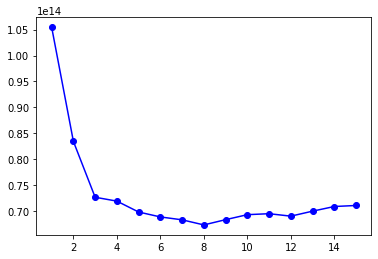

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(rss_dict.keys(), rss_dict.values(),'bo-')

***QUIZ QUESTION ***

What is the RSS on the TEST data using the value of k found above?  To be clear, sum over all houses in the TEST set.
`A = 1.331188e+14`

In [149]:
k = 8
test_outputs = np.array(test['price'])

predictions_test = predict_queries(k, features_train, train_outputs, features_test)

rss_test = get_rss(predictions_test, test_outputs)

test_rss_print = "{:e}".format(rss_test)
print(f"TEST RSS is {rss_test}, or {test_rss_print}")


TEST RSS is 133118823551516.81, or 1.331188e+14
